<img src="Images/1200px-University_of_Tehran_logo.svg.png" width="100" style="float:left;"/>

<img src="Images/fanni.png" width="120" style="float:right;position: relative;top: -25px;"/>


<h1 style="float:center;" align="center">Computer Assignment 4</h1>
<h3 style="float:center;" align="center"><b> Navid Akbari ( 810895023 ) </b></h3>

The goal of this computer assignment is to get more familiar with the linear machine learning classifications methods. These algorithms help us to classify between different categories. In this computer assignment we want to decide whether one person come back to the shop or not.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import calendar
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier, VotingClassifier, RandomForestClassifier
from sklearn.externals.six import StringIO 
from IPython.display import Image 
from pydot import graph_from_dot_data
from difflib import SequenceMatcher

pd.set_option('mode.chained_assignment', None)

/Users/navid/Library/Python/3.7/lib/python/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


First, we read the data from .csv file and check the data info.

In [2]:
data = pd.read_csv('data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4366 entries, 0 to 4365
Data columns (total 8 columns):
Unnamed: 0        4366 non-null int64
Customer ID       4366 non-null int64
Total Quantity    4366 non-null int64
Total Price       4366 non-null float64
Country           4366 non-null object
Date              4366 non-null object
Is Back           4366 non-null object
Purchase Count    4366 non-null int64
dtypes: float64(1), int64(4), object(3)
memory usage: 273.0+ KB


# Data Preprocessing

Next step in each ML problem is to clean data and prepare it for making the best usage of it. Here I define a `dataPreprocessing` function which extract various features from data to get the best result possible. As it's shown in the dataset info we have various type of data type, so we should deal differently with them. I will explain what I have done for each of them seperately.

## Date

Date variables are a special type of categorical variable. While, at first glance, a date gives us nothing more than a specific point on a timeline, when pre-processing properly, they can highly enrich the dataset. Getting dates into a friendly format and extracting features of dates into new variables can be useful preprocessing steps. 
For Example, from a date variable, you can extract basic features like:
* **Day:** Day part of the date.
* **Month:** Month part of the date.
* **Year:** Year part of the date.
* **Sin and Cos form of day, month and week day:** We can map each cyclical variable onto a circle such that the lowest value for that variable appears right next to the largest value. We can do this using `sin` and `cos` trigonometric functions. Maybe, there exist some pattern between cyclical sin or cos with rate of people come back.
* **KSP format:** KSP is a special format of the date. It's calculate by this formula:
<img src="Images/KSP.png" width="300px"/>
* **Day of week:** Which day of week is the given date. Maybe, if it is a special day people come back to store more often.
* **Quarter:** Which quarter is the given date. Maybe, in one special quarter people come to the store more.
* **Semester:** Which semester is the given date. Maybe, in one special semester people come to the store more.
* **Is Weekend?** One boolean variable that shows is the date in the Weekend or not? Maybe, we can find a reasonable relation between weekend days and rate of the backing to the store.
* **Date encoding:** Converting the given date to numbers with feature encoding. This method assign special number for each date. Maybe this feature helps to find a relation between exact date and rate of coming back.  I will explain lable encoding further.
* **Year-Month encoding:** I put both year and month together and by using lable encoding I convert the string of it to a range of the numbers. I use this feature because I thought may be people in one special month and year has more come back rate. I will explain lable encoding further.

## Scaling

When we are working with a learning model, it is important to scale the features to a range which is centered around zero. This is done so that the variance of the features are in the same range. If a feature’s variance is orders of magnitude more than the variance of other features, that particular feature might dominate other features in the dataset, which is not something we want happening in our model. `StandardScaler` standardizes a feature by subtracting the mean and then scaling to unit variance. Unit variance means dividing all the values by the standard deviation. StandardScaler results in a distribution with a standard deviation equal to 1. The variance is equal to 1 also. In our dataset I scaled Total Quantity,	Total Price and Purchase Count, to findout which have more information gain.

## Categorical

Munging categorical data is another essential process during data preprocessing. Before we start transforming our data, it is important to figure out if the feature we are working on is `ordinal` or `nominal`. An ordinal feature is best described as a feature with natural, ordered categories and the distances between the categories is not known. We can use `LabelEncoder` for ordinal features not nominal features. But in nominal features we can’t replace the categories by a number since this would imply the features have an order, which is untrue in case of country. So we should use a nominal encoding. The most popular way to encode nominal features is `one-hot-encoding`. Essentially, each categorical feature with n categories is transformed into n binary features. If the cardinality of the categorical features is low (relative to the amount of data) one-hot encoding will work best. But if the cardinality is large and dataset is small, one-hot encoding may not be feasible, and classifires may not be able to efficiently learn. In our dataset we have sufficient numbers of data so we can use one-hot-encoding here.

## Continuous Data

Often when dealing with continuous numeric attributes like price, we may not need the raw values having a high amount of precision. Hence it often makes sense to round off these high precision information into numeric integers. These integers can then be directly used as raw values. In our dataset we have one feature named `Total Price`, and hence we don't need that much precision I round it to an integer.

In [3]:
def to_ksp_format(datetime):
    year = datetime.year
    day_from_jan_1 = (datetime - dt.datetime(year, 1, 1)).days
    is_leap_year = int(calendar.isleap(year))
    return year + (day_from_jan_1 - 0.5) / (365 + is_leap_year)

def dataPreprocessing(data):
    le = LabelEncoder()
    
    data = data.drop(columns = data.columns[0])
    
    data['Discrete Total Price'] = np.array(np.round((data['Total Price'])),  dtype='int')

    scaler = StandardScaler()
    data['Scaled Total Quantity'] = scaler.fit_transform(data['Total Quantity'].values.reshape(-1,1))
    data['Scaled Total Price'] = scaler.fit_transform(data['Total Price'].values.reshape(-1,1))
    data['Scaled Discrete Total Price'] = scaler.fit_transform(data['Discrete Total Price'].values.reshape(-1,1))
    data['Scaled Purchase Count'] = scaler.fit_transform(data['Purchase Count'].values.reshape(-1,1))

    data['Date'] = pd.to_datetime(data['Date'], format='%Y.%m.%d')
    data['Day'] = data['Date'].dt.day
    data['Month'] = data['Date'].dt.month
    data['Year'] = data['Date'].dt.year
    data['Scaled Month'] = scaler.fit_transform(data['Month'].values.reshape(-1,1))
    data['Scaled Year'] = scaler.fit_transform(data['Year'].values.reshape(-1,1))
    data['day_sin'] = np.sin(data.Day*(2.*np.pi/30))
    data['day_cos'] = np.cos(data.Day*(2.*np.pi/30))
    data['month_sin'] = np.sin((data.Month-1)*(2.*np.pi/12))
    data['month_cos'] = np.cos((data.Month-1)*(2.*np.pi/12))
    data['Year-Month'] = pd.to_datetime(data['Date']).dt.to_period('M')
    data['ksp_date'] = data['Date'].apply(to_ksp_format)
    data['Scaled ksp_date'] = scaler.fit_transform(data['ksp_date'].values.reshape(-1,1))
    data['Day of week'] = data['Date'].dt.dayofweek
    data['quarter'] = data['Date'].dt.quarter
    data['semester'] = np.where(data.quarter.isin([1,2]),1,2)
    data['week sin'] = np.sin((data['Day of week'])*(2.*np.pi/7))
    data['week_cos'] = np.cos((data['Day of week'])*(2.*np.pi/7))
    data['Is Weekend'] = np.where(data['Day of week'].isin([6,7]),1,0)
    le.fit(data['Date'].astype(str))
    data['Date Number'] = le.transform(data['Date'].astype(str))
    data['Scaled Date Number'] = scaler.fit_transform(data['Date Number'].values.reshape(-1,1))
    le.fit(data['Year-Month'].astype(str))
    data['Year-Month Number'] = le.transform(data['Year-Month'].astype(str))
    data['Scaled Year-Month Number'] = scaler.fit_transform(data['Year-Month Number'].values.reshape(-1,1))
   
    le.fit(data['Country'].astype(str))
    data['Country Number'] = le.transform(data['Country'].astype(str))
  
    return data

data = dataPreprocessing(data)
data.head()

,Customer ID,Total Quantity,Total Price,Country,Date,Is Back,Purchase Count,Discrete Total Price,Scaled Total Quantity,Scaled Total Price,...,quarter,semester,week sin,week_cos,Is Weekend,Date Number,Scaled Date Number,Year-Month Number,Scaled Year-Month Number,Country Number
0,16995,-1,-1.25,United Kingdom,2010-12-02,No,1,-1,-0.524359,-0.044660,...,4,2,0.433884,-0.900969,0,1,-1.201816,0,-1.157319,35
1,12552,85,13.52,Italy,2011-10-31,Yes,19,14,-0.338777,-0.032135,...,4,2,0.000000,1.000000,0,270,1.594607,10,1.453705,18
2,13192,298,15.90,United Kingdom,2011-05-18,Yes,33,16,0.120864,-0.030117,...,2,1,0.974928,-0.222521,0,130,0.139219,5,0.148193,35
3,16934,399,8.30,United Kingdom,2011-10-16,No,62,8,0.338815,-0.036562,...,4,2,-0.781831,0.623490,1,257,1.459464,10,1.453705,35
4,14976,27,11.90,United Kingdom,2011-01-17,Yes,16,12,-0.463937,-0.033509,...,1,1,0.000000,1.000000,0,31,-0.889947,1,-0.896216,35


# Information Gain

I calculate information gain for all the extract features from the dataset. I represent them in two seperated table.

In [4]:
def drawInformationGain(features, information_gain, OneHotEncodeInformation_gain):
    table = pd.DataFrame([], index=['Information Gain'] , columns=features[0:16])
    table2 = pd.DataFrame([], index=['Information Gain'] , columns=np.concatenate((features[16:], ['One Hot Encoding'])))

    table.loc['Information Gain'][features[0]] = information_gain[0]
    table.loc['Information Gain'][features[1]] = information_gain[1]
    table.loc['Information Gain'][features[2]] = information_gain[2]
    table.loc['Information Gain'][features[3]] = information_gain[3]
    table.loc['Information Gain'][features[4]] = information_gain[4]
    table.loc['Information Gain'][features[5]] = information_gain[5]
    table.loc['Information Gain'][features[6]] = information_gain[6]
    table.loc['Information Gain'][features[7]] = information_gain[7]
    table.loc['Information Gain'][features[8]] = information_gain[8]
    table.loc['Information Gain'][features[9]] = information_gain[9]
    table.loc['Information Gain'][features[10]] = information_gain[10]
    table.loc['Information Gain'][features[11]] = information_gain[11]
    table.loc['Information Gain'][features[12]] = information_gain[12]
    table.loc['Information Gain'][features[13]] = information_gain[13]
    table.loc['Information Gain'][features[14]] = information_gain[14]
    table2.loc['Information Gain'][features[15]] = information_gain[15]
    table2.loc['Information Gain'][features[16]] = information_gain[16]
    table2.loc['Information Gain'][features[17]] = information_gain[17]
    table2.loc['Information Gain'][features[18]] = information_gain[18]
    table2.loc['Information Gain'][features[19]] = information_gain[19]
    table2.loc['Information Gain'][features[20]] = information_gain[20]
    table2.loc['Information Gain'][features[21]] = information_gain[21]
    table2.loc['Information Gain'][features[22]] = information_gain[22]
    table2.loc['Information Gain'][features[23]] = information_gain[23]
    table2.loc['Information Gain'][features[24]] = information_gain[24]
    table2.loc['Information Gain'][features[25]] = information_gain[25]
    table2.loc['Information Gain'][features[26]] = information_gain[26]
    table2.loc['Information Gain'][features[27]] = information_gain[27]
    table2.loc['Information Gain'][features[28]] = information_gain[28]
    table2.loc['Information Gain'][features[29]] = information_gain[29]
    table2.loc['Information Gain'][features[30]] = information_gain[30]
    table2.loc['Information Gain']['One Hot Encoding'] = OneHotEncodeInformation_gain
    
    return table, table2

features = [x for x in data.columns if x not in ['Country', 'Date', 'Is Back', 'Year-Month']]
X = data[features]
y = data['Is Back']
information_gain = mutual_info_classif(X, y, random_state = 8, discrete_features=[True, True, False, True, True, False, False, False, False, True, True, True, False, False, False, False, False, False, False, False, True, True, True, False, False, True, True, False, True, False, True])
OneHotEncode = pd.get_dummies(data.Country)
OneHotEncodeInformation_gain = mutual_info_classif(OneHotEncode, y, random_state = 8)
table, table2 = drawInformationGain(features, information_gain, sum(OneHotEncodeInformation_gain))
table

,Customer ID,Total Quantity,Total Price,Purchase Count,Discrete Total Price,Scaled Total Quantity,Scaled Total Price,Scaled Discrete Total Price,Scaled Purchase Count,Day,Month,Year,Scaled Month,Scaled Year,day_sin,day_cos
Information Gain,0.623878,0.110854,0.0207032,0.0219258,0.0454068,0,0.0194044,0.00142196,0.000948971,0.0107002,0.0691011,0.028395,0.0521682,0.0249654,0,NaN


In [5]:
table2

,month_sin,month_cos,ksp_date,Scaled ksp_date,Day of week,quarter,semester,week sin,week_cos,Is Weekend,Date Number,Scaled Date Number,Year-Month Number,Scaled Year-Month Number,Country Number,One Hot Encoding
Information Gain,0.049832,0.0508466,0.0748179,0.0840932,0.00125143,0.0127215,0.0103343,0.00283043,0.000672129,2.9174e-05,0.119915,0.0817903,0.0862819,0.094993,0.00524362,0.0896452


# Information Gain Analysis

As it's shown in the plot, the biggest portion of information gain is for `Customer Id`, this matter was expected because this feild id uniqe for each customer. So we can make a good decision based on it for precious data we met, but its useless for new data and hence it cause overfit in our learning. On the other hand, some features like month which they got good information gain too doesn't overfit our data because we just have 12 category in month feature. Another thing that worth mentioning is encoded Date. As we can see in the figure, it got good information gain but similarly its cause overfit in our train data because we got lots of category there and this result is because of it. Similar thing happen to the Total Quantity.

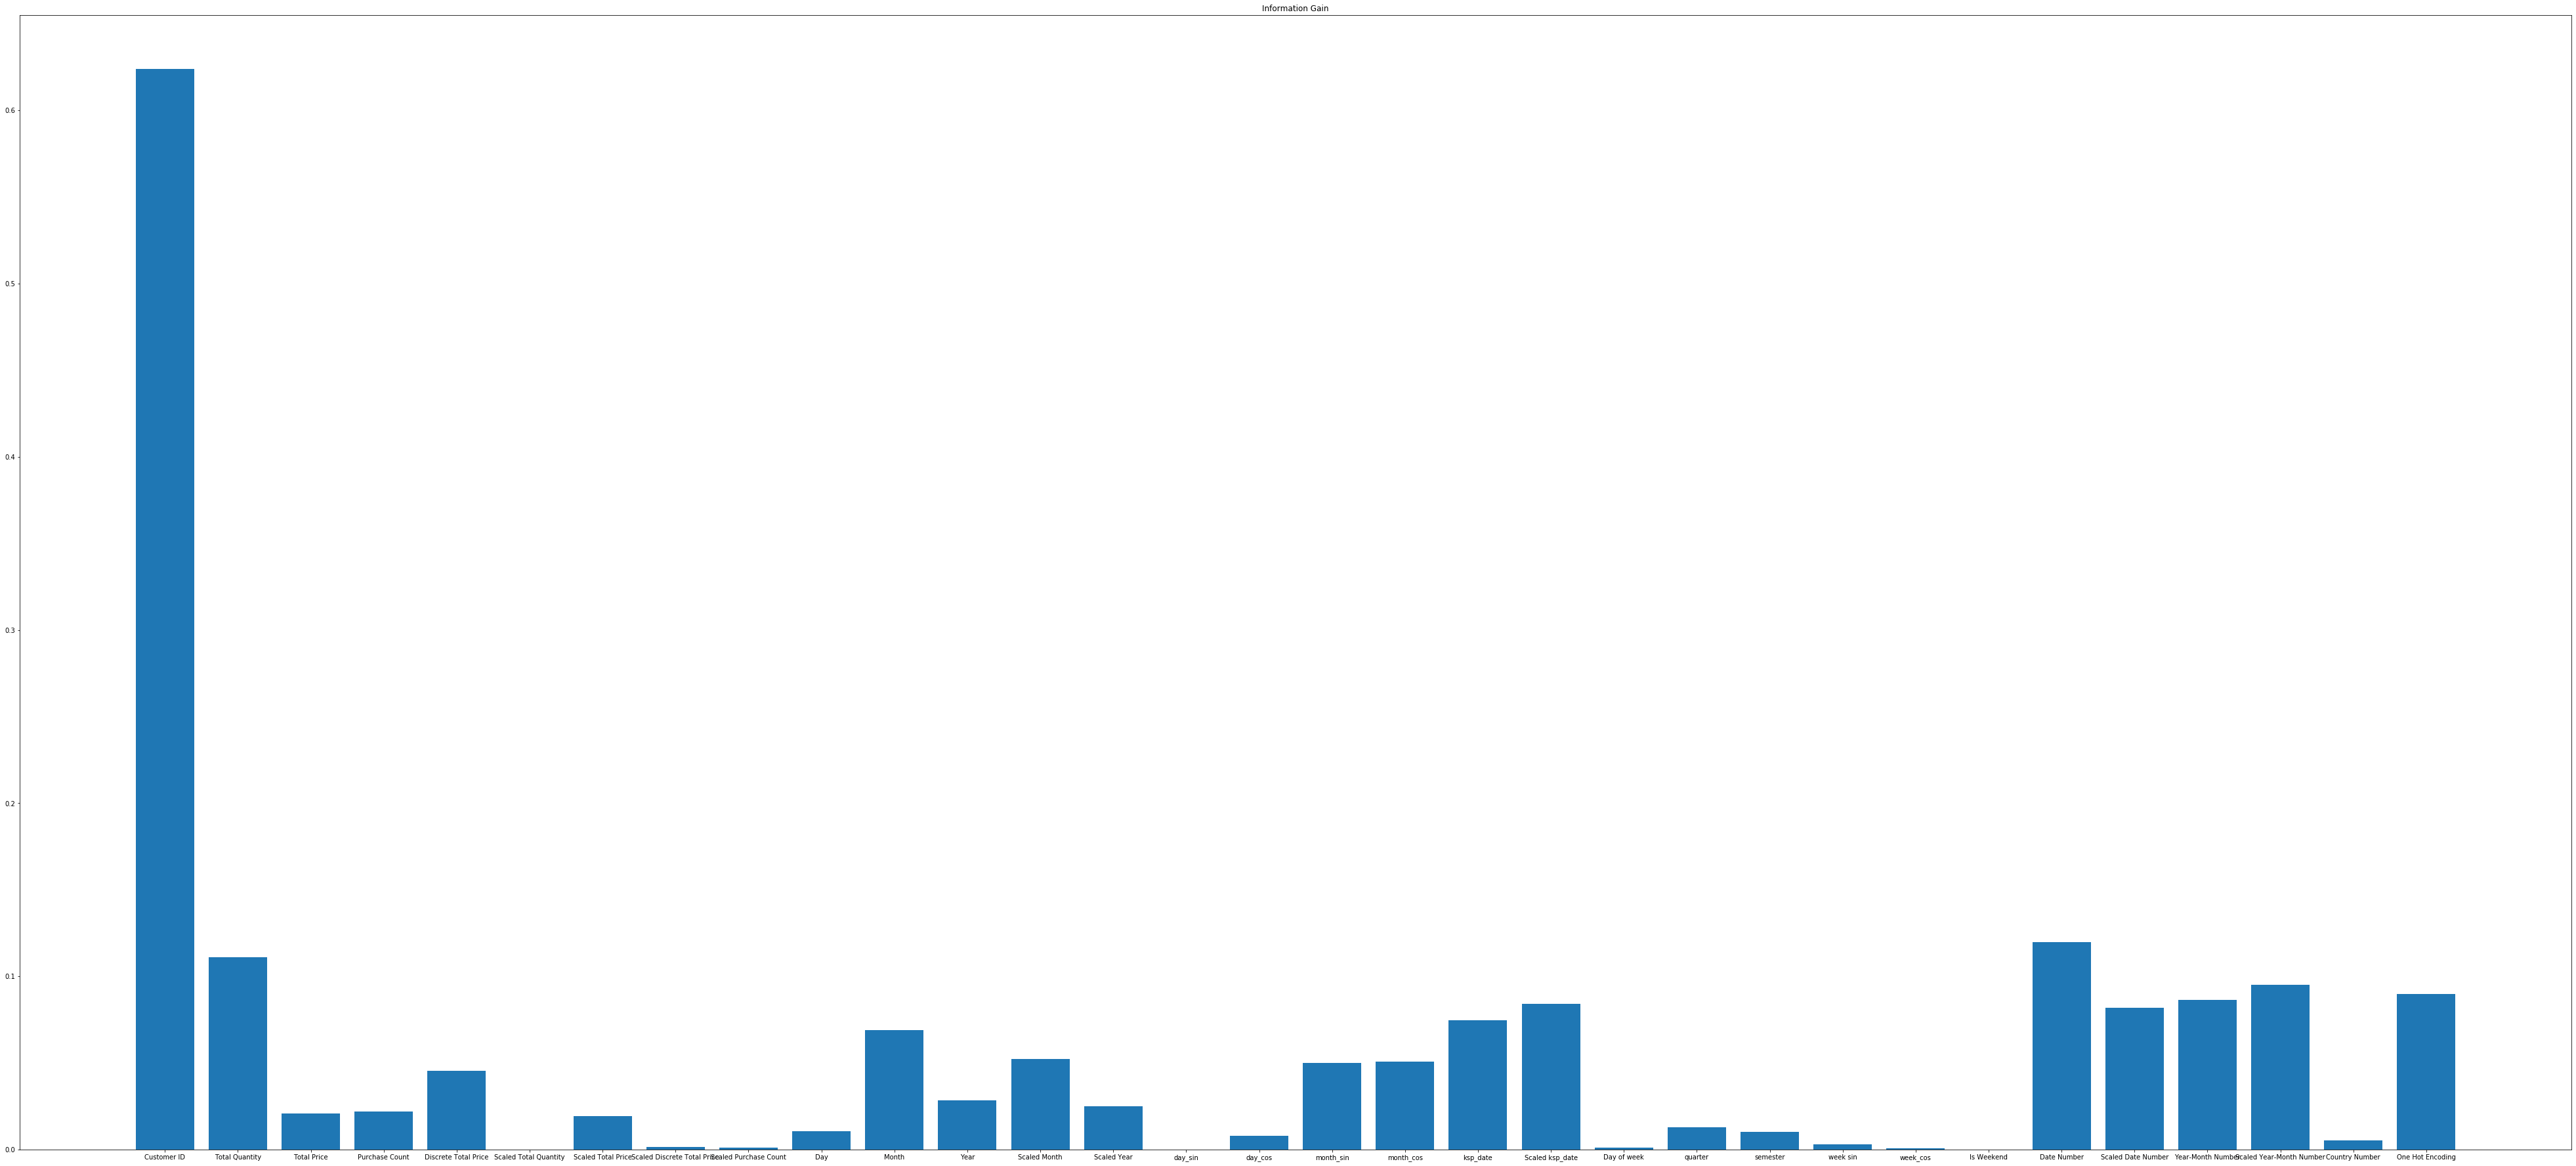

In [6]:
fig = plt.figure()
ax = fig.add_axes([0,0,9,6])
ax.bar(np.concatenate((features, ['One Hot Encoding'])), np.concatenate((information_gain, [sum(OneHotEncodeInformation_gain)])))
plt.title('Information Gain')
plt.show()

# Spliting Train and Test Data

Now, I select features which I got best result with and train all classifications algorithm with them. I didn't choose `Total Quantity`, `Customer ID`, `Date Number`, etc, because they caused overfitting. I selecet `Discrete Total Price`, `Scaled Purchase Count`, `Year`, `Month`, `quarter` and `Country one-hot-encoding` because they have better information gain and they didn't overfit our model.

As we can see from the train set, we have more `Yes` in our model than `No`, so it is possible to get less `recall` and `precision` in this section.

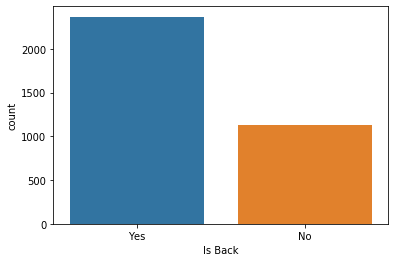

In [7]:
features = ['Discrete Total Price', 'Scaled Purchase Count', 'Year', 'Month', 'quarter']

X = data[features]
X = X.join(OneHotEncode) 
y = data['Is Back']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)
sns.countplot(x=y_train)
plt.show()

# Decision Tree

In this classification method, we learn our dataset with different `max_depth` parameter, from 1 to 100, and then predict the result both on train and test dataset to find the best place which doesnot have overfitting. As we can see in the figure, at the beginning with less depth we don't have overfitting but as the max depth grow we face overfitting in our model. The cause of this matter is obvious, as the max_depth of the tree grow we consider more detail about the train dataset so we can predict it better but on the other hand these detail make accuracy less in the test dataset. I choose the point with the biggest accuracy which can seen that doesn't have overfitting. In the last iterations, when we have about 100 depth, we can see that the accuracy for the train data is 100% and for test data is about 60%.

Accuracy: 0.7654462242562929
Report : 
               precision    recall  f1-score   support

          No       0.66      0.41      0.51       255
         Yes       0.79      0.91      0.85       619

    accuracy                           0.77       874
   macro avg       0.72      0.66      0.68       874
weighted avg       0.75      0.77      0.75       874



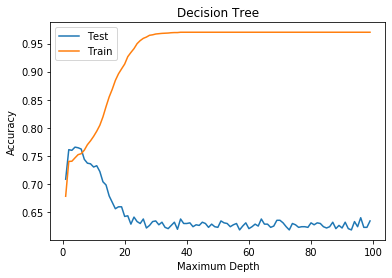

In [8]:
def DecisionTreeClassification():
    trainAccuracy, testAccuracy = [], []
    maxIndex = 0
    maxAccuracy = 0
    for i in list(range(1, 100)):
        decision_tree_classifier = DecisionTreeClassifier(criterion='entropy', max_depth = i)
        decision_tree_classifier = decision_tree_classifier.fit(X_train,y_train)
        test_pred = decision_tree_classifier.predict(X_test)
        train_pred = decision_tree_classifier.predict(X_train)
        testAccuracy.append(metrics.accuracy_score(y_test, test_pred))
        if metrics.accuracy_score(y_test, test_pred) >= maxAccuracy:
            maxAccuracy = metrics.accuracy_score(y_test, test_pred)
            maxIndex = i
        trainAccuracy.append(metrics.accuracy_score(y_train, train_pred))

    decision_tree_classifier = DecisionTreeClassifier(criterion='entropy', max_depth = maxIndex)
    decision_tree_classifier.fit(X_train, y_train)
    y_pred = decision_tree_classifier.predict(X_test)
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print("Report : \n", classification_report(y_test, y_pred))

    plt.plot(list(range(1, 100)),testAccuracy, label='Test')
    plt.plot(list(range(1, 100)), trainAccuracy, label='Train')
    plt.ylabel('Accuracy')
    plt.xlabel('Maximum Depth')
    plt.title('Decision Tree')
    plt.legend()
    plt.show()

    return decision_tree_classifier
   
decision_tree_classifier = DecisionTreeClassification()

Here, I draw the decision tree which my model will classify the data based on. As we can see it's got depth of four.

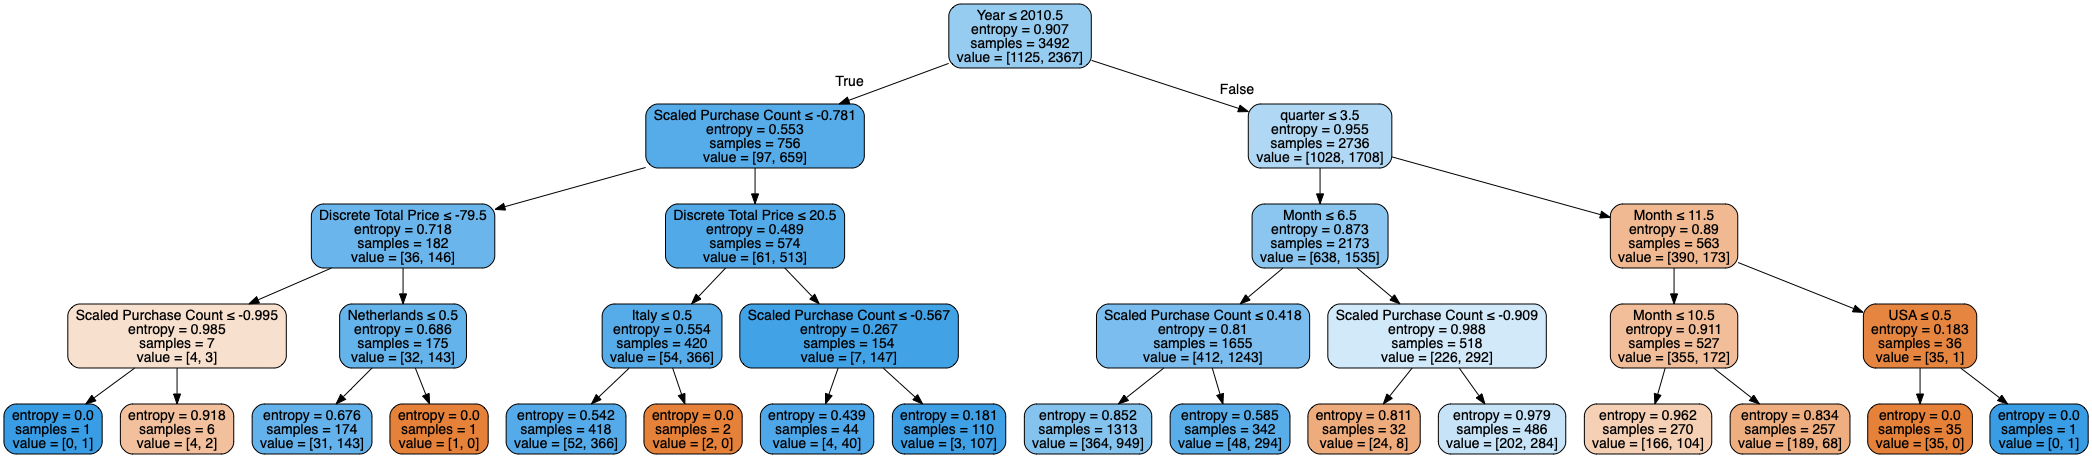

In [9]:
dot_data = StringIO()
export_graphviz(decision_tree_classifier, out_file=dot_data, feature_names=X_train.columns, filled=True, rounded=True, special_characters=True,)
(graph, ) = graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

# K Nearest Neighbours

In this classification method, we learn our dataset with different `n_neighbors` parameter, from 1 to 100, and then predict the result both on train and test dataset to find the best place which doesnot have overfitting. As it's shown in the figure, after some fluctuation the accuracy become stable and doesn't change alot. As the differences between train and test accuracy is not alot we don't have overfitting or underfitting here. At first in the low number of neighbours the accuracy for the train set is much more because its just see its self and decide based on its self.

Accuracy: 0.7471395881006865
Report : 
               precision    recall  f1-score   support

          No       0.62      0.34      0.44       255
         Yes       0.77      0.91      0.84       619

    accuracy                           0.75       874
   macro avg       0.70      0.63      0.64       874
weighted avg       0.73      0.75      0.72       874



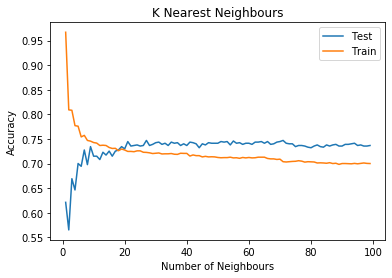

In [10]:
def KـNearestNeighboursClassification():
    trainAccuracy, testAccuracy = [], []
    maxIndex = 0
    maxAccuracy = 0
    for i in list(range(1,100)):
        KNN = KNeighborsClassifier(n_neighbors = i)
        KNN = KNN.fit(X_train, y_train)
        test_pred = KNN.predict(X_test)
        train_pred = KNN.predict(X_train)
        testAccuracy.append(metrics.accuracy_score(y_test, test_pred))
        if metrics.accuracy_score(y_test, test_pred) > maxAccuracy:
            maxAccuracy = metrics.accuracy_score(y_test, test_pred)
            maxIndex = i
        trainAccuracy.append(metrics.accuracy_score(y_train, train_pred))


    KNN = KNeighborsClassifier(n_neighbors = maxIndex)
    KNN = KNN.fit(X_train, y_train)
    y_pred = KNN.predict(X_test)
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print("Report : \n", classification_report(y_test, y_pred))

    plt.plot(list(range(1, 100)),testAccuracy, label='Test')
    plt.plot(list(range(1, 100)), trainAccuracy, label='Train')
    plt.ylabel('Accuracy')
    plt.xlabel('Number of Neighbours')
    plt.title('K Nearest Neighbours')
    plt.legend()
    plt.show()
    
    return KNN

KNN = KـNearestNeighboursClassification()

# Logistic Classiﬁer

Logistic regression is another technique borrowed by machine learning from the field of statistics. Logistic regression is named for the function used at the core of the method, the logistic function.

In [11]:
logisticRegr = LogisticRegression()
logisticRegr = logisticRegr.fit(X_train, y_train)
y_pred = logisticRegr.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Report : \n", classification_report(y_test, y_pred))

Accuracy: 0.7299771167048055
Report : 
               precision    recall  f1-score   support

          No       0.67      0.15      0.24       255
         Yes       0.73      0.97      0.84       619

    accuracy                           0.73       874
   macro avg       0.70      0.56      0.54       874
weighted avg       0.71      0.73      0.66       874



# Bagging

A Bagging classifier is an ensemble meta-estimator that fits base classifiers each on random subsets of the original dataset and then aggregate their individual predictions by voting or by averaging to form a final prediction. Such a meta-estimator can typically be used as a way to reduce the variance by introducing randomization into its construction procedure and then making an ensemble out of it. Bagging reduces overfitting (variance) by averaging or voting, however, this leads to an increase in bias, which is compensated by the reduction in variance though.

# Decision Tree Bagging

For this part I choose the best result I got in decision tree classification for using in the bagging algorithm.

In [12]:
decistion_tree_bagging = BaggingClassifier(decision_tree_classifier, max_samples=0.5, max_features=0.5)
decistion_tree_bagging = decistion_tree_bagging.fit(X_train, y_train)
y_pred = decistion_tree_bagging.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Report : \n", classification_report(y_test, y_pred))

Accuracy: 0.7665903890160183
Report : 
               precision    recall  f1-score   support

          No       0.67      0.40      0.50       255
         Yes       0.79      0.92      0.85       619

    accuracy                           0.77       874
   macro avg       0.73      0.66      0.67       874
weighted avg       0.75      0.77      0.75       874



# K Nearest Neighbours Bagging

For this part I choose the best result I got in k Nearest Neighbours classification for using in the bagging algorithm.

In [13]:
KNN_bagging = BaggingClassifier(KNN, max_samples=0.5, max_features=0.5)
KNN_bagging = KNN_bagging.fit(X_train, y_train)
y_pred = KNN_bagging.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Report : \n", classification_report(y_test, y_pred))

Accuracy: 0.7254004576659039
Report : 
               precision    recall  f1-score   support

          No       0.65      0.13      0.21       255
         Yes       0.73      0.97      0.83       619

    accuracy                           0.73       874
   macro avg       0.69      0.55      0.52       874
weighted avg       0.71      0.73      0.65       874



# Random Forest

Random forest is an extension of bagged decision trees. In this part I check effect of two hyperparameters. 
### Number of Estimators
The first one is `n_estimators`, I change it from 1 to 100 and draw the relevant figure. As it's shown in the figure this model got overfitting, but the reason for this matter is `max_depth` parameter. Because this parameter set to the None in default configuration, so the documentation said that: "If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples." So the trees depth go to far and as I state previously, as much as the depth grow we got more overfitting in our model.

### Maximum Depth
The second parameter is `max_depth`, I change it from 1 to 100 and draw the relevant figure. As we can see from the plot, overfitting becomes more by making max depth bigger. This is because when we have bigger tree in our model we consider the details more and this matter resulted to overfitting. 

Accuracy for Number of Estimators: 

Accuracy: 0.6899313501144165
Report : 
               precision    recall  f1-score   support

          No       0.47      0.43      0.45       255
         Yes       0.77      0.80      0.78       619

    accuracy                           0.69       874
   macro avg       0.62      0.61      0.62       874
weighted avg       0.68      0.69      0.69       874



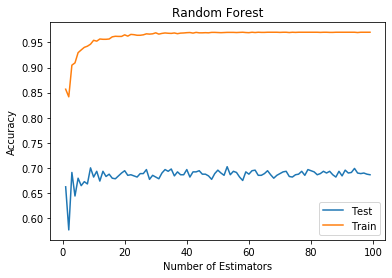


 Accuracy for the maximum depth of the tree: 

Accuracy: 0.7700228832951945
Report : 
               precision    recall  f1-score   support

          No       0.67      0.42      0.51       255
         Yes       0.79      0.92      0.85       619

    accuracy                           0.77       874
   macro avg       0.73      0.67      0.68       874
weighted avg       0.76      0.77      0.75       874



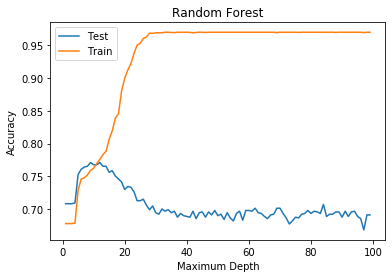

In [14]:
def randomForestClassification():
    trainAccuracy, testAccuracy = [], []
    maxIndex = 0
    maxAccuracy = 0
    for i in list(range(1, 100)):
        randomForest = RandomForestClassifier(n_estimators = i, criterion="entropy")
        randomForest = randomForest.fit(X_train, y_train)
        test_pred = randomForest.predict(X_test)
        train_pred = randomForest.predict(X_train)
        testAccuracy.append(metrics.accuracy_score(y_test, test_pred))
        if metrics.accuracy_score(y_test, test_pred) > maxAccuracy:
            maxAccuracy = metrics.accuracy_score(y_test, test_pred)
            maxIndex = i
        trainAccuracy.append(metrics.accuracy_score(y_train, train_pred))


    randomForest = RandomForestClassifier(n_estimators = maxIndex, criterion="entropy")
    randomForest.fit(X_train, y_train)
    y_pred = randomForest.predict(X_test)
    print("Accuracy for Number of Estimators: \n")
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print("Report : \n", classification_report(y_test, y_pred))

    plt.plot(list(range(1, 100)),testAccuracy, label='Test')
    plt.plot(list(range(1, 100)), trainAccuracy, label='Train')
    plt.ylabel('Accuracy')
    plt.xlabel('Number of Estimators')
    plt.title('Random Forest')
    plt.legend()
    plt.show()

    trainAccuracy, testAccuracy = [], []
    maxIndex = 0
    maxAccuracy = 0
    for i in list(range(1, 100)):
        randomForest = RandomForestClassifier(max_depth = i, criterion="entropy")
        randomForest = randomForest.fit(X_train, y_train)
        test_pred = randomForest.predict(X_test)
        train_pred = randomForest.predict(X_train)
        testAccuracy.append(metrics.accuracy_score(y_test, test_pred))
        if metrics.accuracy_score(y_test, test_pred) > maxAccuracy:
            maxAccuracy = metrics.accuracy_score(y_test, test_pred)
            maxIndex = i
        trainAccuracy.append(metrics.accuracy_score(y_train, train_pred))


    randomForest = RandomForestClassifier(max_depth = maxIndex, criterion="entropy")
    randomForest = randomForest.fit(X_train, y_train)
    y_pred = randomForest.predict(X_test)
    print("\n Accuracy for the maximum depth of the tree: \n")
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print("Report : \n", classification_report(y_test, y_pred))

    plt.plot(list(range(1, 100)),testAccuracy, label='Test')
    plt.plot(list(range(1, 100)), trainAccuracy, label='Train')
    plt.ylabel('Accuracy')
    plt.xlabel('Maximum Depth')
    plt.title('Random Forest')
    plt.legend()
    plt.show()
    
    return randomForest

randomForest = randomForestClassification()

# Effects of Bagging on Overfitting

For finding the effect of bagging algorithms on overfitting, I emplement a model with high overfitting which we saw it previously on the Decision Tree Classification part. As we see in this figure we have overfitting in our model in deep depth.
<img src="Images/overfitting.png" width="400px"/>

But if we use bagging algorithm, even in the deepest depth we don't have overfitting any more. So Bagging solve the overfiting problem. Bagging seperate inputs in fewer inputs points and train a decision tree with low depth factor on it. It doesn't train all data with one classifire, but it will distribute data between varouis classifires and then choose the best result from them. This method result to fewer overfitting.

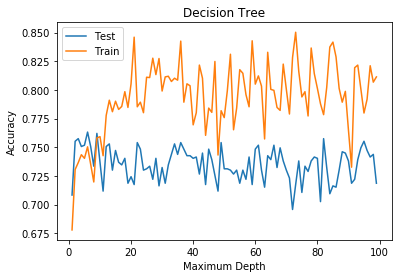

In [15]:
def BaggingDecisionTreeClassification():
    trainAccuracy, testAccuracy = [], []
    maxIndex = 0
    maxAccuracy = 0
    for i in list(range(1, 100)):
        bagging_decision_tree_classifier = DecisionTreeClassifier(criterion='entropy', max_depth = i)
        bagging = BaggingClassifier(bagging_decision_tree_classifier, max_samples=0.5, max_features=0.5)
        bagging = bagging.fit(X_train, y_train)
        test_pred = bagging.predict(X_test)
        train_pred = bagging.predict(X_train)
        testAccuracy.append(metrics.accuracy_score(y_test, test_pred))
        if metrics.accuracy_score(y_test, test_pred) >= maxAccuracy:
            maxAccuracy = metrics.accuracy_score(y_test, test_pred)
            maxIndex = i
        trainAccuracy.append(metrics.accuracy_score(y_train, train_pred))


    plt.plot(list(range(1, 100)),testAccuracy, label='Test')
    plt.plot(list(range(1, 100)), trainAccuracy, label='Train')
    plt.ylabel('Accuracy')
    plt.xlabel('Maximum Depth')
    plt.title('Decision Tree')
    plt.legend()
    plt.show()

    
BaggingDecisionTreeClassification()

# What is bootstrapping?

The bootstrap method is a resampling technique used to estimate statistics on a population by sampling a dataset with replacement. Bootstrapping introduces a bit more diversity in the subsets that each predictor is trained on, so bagging ends up with a slightly higher bias than pasting, but this also means that predictors end up being less correlated so the ensemble’s variance is reduced. Overall, bagging often results in better models, which explains why it is generally preferred.

# Hard-Voting

This method for classification, use different type of classifiers and at the end get vote from the result and choose the best result. This model usually has the result of the best classifiers.

In [16]:
hardVoting = VotingClassifier(
	                            estimators = [('Decision Tree', decision_tree_classifier), ('K neighbors', KNN), ('Logistic Reg',logisticRegr)],
	                            voting = 'hard')
hardVoting = hardVoting.fit(X_train, y_train)
y_pred = hardVoting.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Report : \n", classification_report(y_test, y_pred))

Accuracy: 0.7551487414187643
Report : 
               precision    recall  f1-score   support

          No       0.66      0.33      0.44       255
         Yes       0.77      0.93      0.84       619

    accuracy                           0.76       874
   macro avg       0.72      0.63      0.64       874
weighted avg       0.74      0.76      0.73       874



# Similarities

As it's shown in the table we can conclude that `decision tree`, `K neighbours` and `logistic` algorithm are similar some how. Or somehow our data is in a way that each classifier predict it in same way.

In [17]:
def findSimilarity(firstArray, secondArray):
    count = 0
    for i in range(len(firstArray)):
        if firstArray[i] == secondArray[i]:
            count = count + 1
    return count/len(firstArray)

def similarityTable():
    decision_tree_classifier_pred = decision_tree_classifier.predict(X_test)
    KNN_pred = KNN.predict(X_test)
    logisticRegr_pred = logisticRegr.predict(X_test)
    decistion_tree_bagging_pred = decistion_tree_bagging.predict(X_test)
    KNN_bagging_pred = KNN_bagging.predict(X_test)
    randomForest_pred = randomForest.predict(X_test)
    hardVoting_pred = hardVoting.predict(X_test)
    
    table = pd.DataFrame([], index=['Decision Tree', 'K Neighbours', 'Logistic', 'Decision Tree Bagging', 'K Neighbours Bagging', 'Random Forest', 'Hard Voting'] 
                            , columns=['Decision Tree', 'K Neighbours', 'Logistic', 'Decision Tree Bagging', 'K Neighbours Bagging', 'Random Forest', 'Hard Voting'])
    
    table.loc['Decision Tree']['Decision Tree'] = findSimilarity(decision_tree_classifier_pred, decision_tree_classifier_pred)
    table.loc['Decision Tree']['K Neighbours'] = findSimilarity(decision_tree_classifier_pred, KNN_pred)
    table.loc['Decision Tree']['Logistic'] = findSimilarity(decision_tree_classifier_pred, logisticRegr_pred)
    table.loc['Decision Tree']['Decision Tree Bagging'] = findSimilarity(decision_tree_classifier_pred, decistion_tree_bagging_pred)
    table.loc['Decision Tree']['K Neighbours Bagging'] = findSimilarity(decision_tree_classifier_pred, KNN_bagging_pred)
    table.loc['Decision Tree']['Random Forest'] = findSimilarity(decision_tree_classifier_pred, randomForest_pred)
    table.loc['Decision Tree']['Hard Voting'] = findSimilarity(decision_tree_classifier_pred, hardVoting_pred)
    
    table.loc['K Neighbours']['Decision Tree'] = findSimilarity(KNN_pred, decision_tree_classifier_pred)
    table.loc['K Neighbours']['K Neighbours'] = findSimilarity(KNN_pred, KNN_pred)
    table.loc['K Neighbours']['Logistic'] = findSimilarity(KNN_pred, logisticRegr_pred)
    table.loc['K Neighbours']['Decision Tree Bagging'] = findSimilarity(KNN_pred, decistion_tree_bagging_pred)
    table.loc['K Neighbours']['K Neighbours Bagging'] = findSimilarity(KNN_pred, KNN_bagging_pred)
    table.loc['K Neighbours']['Random Forest'] = findSimilarity(KNN_pred, randomForest_pred)
    table.loc['K Neighbours']['Hard Voting'] = findSimilarity(KNN_pred, hardVoting_pred)
    
    table.loc['Logistic']['Decision Tree'] = findSimilarity(logisticRegr_pred, decision_tree_classifier_pred)
    table.loc['Logistic']['K Neighbours'] = findSimilarity(logisticRegr_pred, KNN_pred)
    table.loc['Logistic']['Logistic'] = findSimilarity(logisticRegr_pred, logisticRegr_pred)
    table.loc['Logistic']['Decision Tree Bagging'] = findSimilarity(logisticRegr_pred, decistion_tree_bagging_pred)
    table.loc['Logistic']['K Neighbours Bagging'] = findSimilarity(logisticRegr_pred, KNN_bagging_pred)
    table.loc['Logistic']['Random Forest'] = findSimilarity(logisticRegr_pred, randomForest_pred)
    table.loc['Logistic']['Hard Voting'] = findSimilarity(logisticRegr_pred, hardVoting_pred)

    table.loc['Decision Tree Bagging']['Decision Tree'] = findSimilarity(decistion_tree_bagging_pred, decision_tree_classifier_pred)
    table.loc['Decision Tree Bagging']['K Neighbours'] = findSimilarity(decistion_tree_bagging_pred, KNN_pred)
    table.loc['Decision Tree Bagging']['Logistic'] = findSimilarity(decistion_tree_bagging_pred, logisticRegr_pred)
    table.loc['Decision Tree Bagging']['Decision Tree Bagging'] = findSimilarity(decistion_tree_bagging_pred, decistion_tree_bagging_pred)
    table.loc['Decision Tree Bagging']['K Neighbours Bagging'] = findSimilarity(decistion_tree_bagging_pred, KNN_bagging_pred)
    table.loc['Decision Tree Bagging']['Random Forest'] = findSimilarity(decistion_tree_bagging_pred, randomForest_pred)
    table.loc['Decision Tree Bagging']['Hard Voting'] = findSimilarity(decistion_tree_bagging_pred, hardVoting_pred)

    table.loc['K Neighbours Bagging']['Decision Tree'] = findSimilarity(KNN_bagging_pred, decision_tree_classifier_pred)
    table.loc['K Neighbours Bagging']['K Neighbours'] = findSimilarity(KNN_bagging_pred, KNN_pred)
    table.loc['K Neighbours Bagging']['Logistic'] = findSimilarity(KNN_bagging_pred, logisticRegr_pred)
    table.loc['K Neighbours Bagging']['Decision Tree Bagging'] = findSimilarity(KNN_bagging_pred, decistion_tree_bagging_pred)
    table.loc['K Neighbours Bagging']['K Neighbours Bagging'] = findSimilarity(KNN_bagging_pred, KNN_bagging_pred)
    table.loc['K Neighbours Bagging']['Random Forest'] = findSimilarity(KNN_bagging_pred, randomForest_pred)
    table.loc['K Neighbours Bagging']['Hard Voting'] = findSimilarity(KNN_bagging_pred, hardVoting_pred)
    
    table.loc['Random Forest']['Decision Tree'] = findSimilarity(randomForest_pred, decision_tree_classifier_pred)
    table.loc['Random Forest']['K Neighbours'] = findSimilarity(randomForest_pred, KNN_pred)
    table.loc['Random Forest']['Logistic'] = findSimilarity(randomForest_pred, logisticRegr_pred)
    table.loc['Random Forest']['Decision Tree Bagging'] = findSimilarity(randomForest_pred, decistion_tree_bagging_pred)
    table.loc['Random Forest']['K Neighbours Bagging'] = findSimilarity(randomForest_pred, KNN_bagging_pred)
    table.loc['Random Forest']['Random Forest'] = findSimilarity(randomForest_pred, randomForest_pred)
    table.loc['Random Forest']['Hard Voting'] = findSimilarity(randomForest_pred, hardVoting_pred)

    table.loc['Hard Voting']['Decision Tree'] = findSimilarity(hardVoting_pred, decision_tree_classifier_pred)
    table.loc['Hard Voting']['K Neighbours'] = findSimilarity(hardVoting_pred, KNN_pred)
    table.loc['Hard Voting']['Logistic'] = findSimilarity(hardVoting_pred, logisticRegr_pred)
    table.loc['Hard Voting']['Decision Tree Bagging'] = findSimilarity(hardVoting_pred, decistion_tree_bagging_pred)
    table.loc['Hard Voting']['K Neighbours Bagging'] = findSimilarity(hardVoting_pred, KNN_bagging_pred)
    table.loc['Hard Voting']['Random Forest'] = findSimilarity(hardVoting_pred, randomForest_pred)
    table.loc['Hard Voting']['Hard Voting'] = findSimilarity(hardVoting_pred, hardVoting_pred)
    
    return table

table = similarityTable()
table

,Decision Tree,K Neighbours,Logistic,Decision Tree Bagging,K Neighbours Bagging,Random Forest,Hard Voting
Decision Tree,1,0.91762,0.882151,0.991991,0.870709,0.990847,0.962243
K Neighbours,0.91762,1,0.875286,0.923341,0.895881,0.922197,0.955378
Logistic,0.882151,0.875286,1,0.89016,0.926773,0.884439,0.919908
Decision Tree Bagging,0.991991,0.923341,0.89016,1,0.878719,0.987414,0.967963
K Neighbours Bagging,0.870709,0.895881,0.926773,0.878719,1,0.872998,0.908467
Random Forest,0.990847,0.922197,0.884439,0.987414,0.872998,1,0.964531
Hard Voting,0.962243,0.955378,0.919908,0.967963,0.908467,0.964531,1


At last, we can see that ensemble learning didn't help our model. These methods are used more for reducing `variance` or making `bias` better and totally they help the model to not become overfit. Also, they could work better if we work more on their hyperparameters. They got lots of hyperparameters that should define well to fet us the result we want. On the other hand, our dataset could be the problem here. Maybe it's somehow in the way that ensemble methods can't deal with it and just can give us the result which one of them gave us. Also, these classifires are very similar together for example `Decision Tree` and `Random Forest` are somehow the same because they predict 99% similar.